In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from data_models.basic import LinearData, LinearDataCorrelated, LinearDataTest
from conformal_prediction.basic import SplitConformal, QuantileConformal
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import copy
import matplotlib.patches as mpatches
from collections import defaultdict
import statsmodels.formula.api as smf
import aux_funcs
import json
from scipy.stats import foldnorm, norm
from scipy.stats import pearsonr, t

In [28]:
weights=np.array([8, 4, 0.1, -0.1, 8, -8, -4, -3, 1, 5])

In [82]:
plot = None
B = 100
model = RandomForestRegressor()
conformal_type = SplitConformal
alpha = 0.05

boot_cov = []
boot_size = []
boot_cov_1 = defaultdict(list)
boot_size_1 = defaultdict(list)
boot_IoU_1 = defaultdict(list)
boot_cov_2 = defaultdict(list)
boot_size_2 = defaultdict(list)
boot_IoU_2 = defaultdict(list)
vars_LOCO = defaultdict(list)

for i in range(B):

    if i % 10 == 0:
        print(i)

    num_samples = 10000
    mu = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    cov_matrix = np.eye(N=10)
    split_percentages=[0.7, 0.2, 0.10]

    # lineardata = LinearDataTest(n=num_samples, a=100, weights=weights)
    lineardata = LinearDataCorrelated(n=num_samples, mu=mu, cov_matrix=cov_matrix, std=1, weights=weights)
    # lineardata = LinearData(n=num_samples, split_percentages=split_percentages, weights=weights)
    lineardata.X_y_split(y='Y')

    pred_all, cov, size, model_trained = aux_funcs.full_conformal(model, data_model=lineardata, conformal_class=conformal_type, alpha=alpha)

    boot_cov.append(cov)
    boot_size.append(size)

    data_X_train = copy.copy(lineardata.train_data_X)
    data_X_calib = copy.copy(lineardata.calib_data_X)
    data_X_test = copy.copy(lineardata.test_data_X)
    
    for variable in lineardata.calib_data_X.columns:

        # Train Twice
        
        data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
        data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
        data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

        pred_j_2, cov_j_2, size_j_2, model_j_2 = aux_funcs.train_twice_conformal(model=model, 
                                                                      modified_data={'train': data_X_train_j_2, 'calib': data_X_calib_j_2, 'test': data_X_test_j_2},
                                                                      data_model=lineardata, conformal_class=conformal_type, 
                                                                      alpha=alpha, evaluate=False, model_return=True)
        
        IoU_2 = aux_funcs.IOU(pred_all, pred_j_2)

        boot_cov_2[variable].extend([cov_j_2])
        boot_size_2[variable].extend([size_j_2])
        boot_IoU_2[variable].extend([IoU_2])

        # Train Once
        data_X_calib_j_1 = copy.copy(lineardata.calib_data_X)
        data_X_calib_j_1[variable] = 0
        data_X_test_j_1 = copy.copy(lineardata.test_data_X)
        data_X_test_j_1[variable] = 0   

        pred_j_1, cov_j_1, size_j_1 = aux_funcs.train_once_conformal(model=model_trained, 
                                                                     modified_data={'calib': data_X_calib_j_1, 'test': data_X_test_j_1},
                                                                     data_model=lineardata, conformal_class=conformal_type, 
                                                                     alpha=alpha, evaluate=True)

        IoU_1 = aux_funcs.IOU(pred_all, pred_j_1)

        boot_cov_1[variable].extend([cov_j_1])
        boot_size_1[variable].extend([size_j_1])
        boot_IoU_1[variable].extend([IoU_1])

        # LOCO
        vars_LOCO[variable].extend([np.median(abs(lineardata.test_data_y-model_j_2.predict(data_X_test_j_2))-abs(lineardata.test_data_y-model_trained.predict(data_X_test)))])

        if plot:
            y_j_1 = pred_j_1[:plot]
            y_j_2 = pred_j_2[:plot]
            y_all = pred_all[:plot]
            x = np.array(range(len(y_j_1)))

            plt.figure(figsize=(12, 4))
            plt.plot((x+0.2,x+0.2),([i for (i,j) in y_all], [j for (i,j) in y_all]),c='black', solid_capstyle='projecting')
            plt.plot((x,x),([i for (i,j) in y_j_1], [j for (i,j) in y_j_1]),c='red')
            plt.plot((x-0.2,x-0.2),([i for (i,j) in y_j_1], [j for (i,j) in y_j_1]),c='green')

            red_patch = mpatches.Patch(color='black', label='Conformal Set with ALL Features')
            blue_patch = mpatches.Patch(color='red', label='Conformal Set without ONE Feature Using CP-1')
            green_patch = mpatches.Patch(color='green', label='Conformal Set without ONE Feature Using CP-2')

            plt.xlabel('Test Observation (X_{n+i})')
            plt.ylabel('Conformal Set Interval')
            plt.title('Variable Importance for feature \n ' + variable)
            plt.legend(handles=[red_patch, blue_patch, green_patch], loc='upper right')
            plt.show()

# if not plot:

#     with open('data_results/Linear_Regression/rf_split_coverage_full.json', 'w') as fp:
#         json.dump(boot_cov, fp)

#     with open('data_results/Linear_Regression/rf_split_size_full.json', 'w') as fp:
#         json.dump(boot_size, fp)

#     with open('data_results/Linear_Regression/rf_split_train_once_coverage.json', 'w') as fp:
#         json.dump(boot_cov_1, fp)

#     with open('data_results/Linear_Regression/rf_split_train_once_size.json', 'w') as fp:
#         json.dump(boot_size_1, fp)

#     with open('data_results/Linear_Regression/rf_split_train_once_IoU.json', 'w') as fp:
#         json.dump(boot_IoU_1, fp)

#     with open('data_results/Linear_Regression/rf_split_train_twice_coverage.json', 'w') as fp:
#         json.dump(boot_cov_2, fp)

#     with open('data_results/Linear_Regression/rf_split_train_twice_size.json', 'w') as fp:
#         json.dump(boot_size_2, fp)

#     with open('data_results/Linear_Regression/rf_split_train_twice_IoU.json', 'w') as fp:
#         json.dump(boot_IoU_2, fp)

0
10
20
30
40
50
60
70
80
90


In [83]:
import scipy

CP1 = []
CP2 = []
LOCO = []
yerr_1 = []
yerr_2 = []
yerr_LOCO = []

for i, variable in enumerate(lineardata.calib_data_X.columns):

    CP1.append(np.mean(np.array(boot_size_1[variable]) - np.array(boot_size)))
    CP2.append(np.mean(np.array(boot_size_2[variable]) - np.array(boot_size)))
    LOCO.append(np.mean(vars_LOCO[variable]))

    std_1 = np.std(np.array(boot_size_1[variable]) - np.array(boot_size), ddof=1)
    std_2 = np.std(np.array(boot_size_2[variable]) - np.array(boot_size), ddof=1)
    std_LOCO = np.std(vars_LOCO[variable], ddof=1)
    h_1 = scipy.stats.norm.ppf(1-0.2/2)*std_1
    yerr_1.append(h_1)
    h_2 = scipy.stats.norm.ppf(1-0.2/2)*std_2
    yerr_2.append(h_2)
    h_LOCO = scipy.stats.norm.ppf(1-0.2/2)*std_LOCO
    yerr_LOCO.append(h_LOCO)

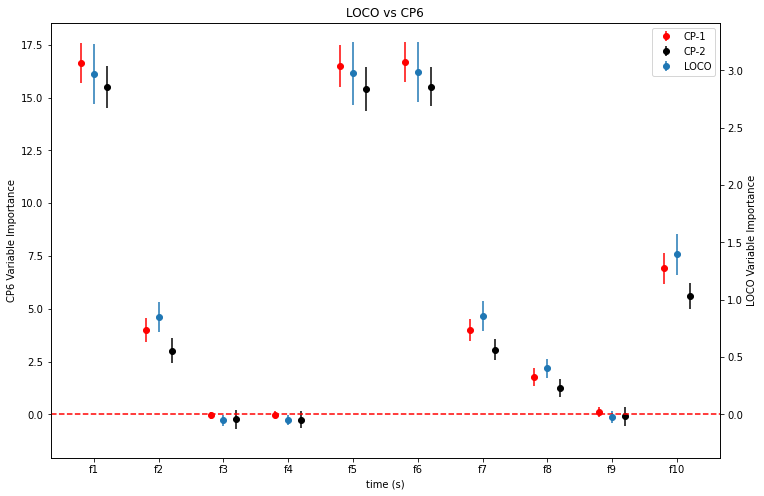

In [85]:
from matplotlib.transforms import Affine2D
from mpl_axes_aligner import align

x = lineardata.calib_data_X.columns

fig, ax1 = plt.subplots(figsize=(12,8))

trans1 = Affine2D().translate(-0.2, 0.0) + ax1.transData
trans2 = Affine2D().translate(+0.2, 0.0) + ax1.transData
ax1.set_xlabel('time (s)')
ax1.set_ylabel('CP6 Variable Importance')
p1 = ax1.errorbar(x, CP1, yerr=yerr_1, fmt='o', transform=trans1, color='red', label='CP-1')
p2 = ax1.errorbar(x, CP2, yerr=yerr_2, fmt='o', transform=trans2, color='black', label='CP-2')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('LOCO Variable Importance') 
p3 = ax2.errorbar(x, LOCO, yerr=yerr_LOCO, fmt='o', label='LOCO')
plt.axline(xy1=(0, 0), slope=0, color='r', linestyle='--')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.title('LOCO vs CP6')

# Adjust the plotting range of two y axes
org1 = 0.0  # Origin of first axis
org2 = 0.0  # Origin of second axis
pos = 0.1  # Position the two origins are aligned
align.yaxes(ax1, org1, ax2, org2, pos)
plt.savefig('images/LOCO_vs_CP6_RF_many')
plt.show()

In [49]:
f = open('data_results/Linear_Regression/linear_quantile_size_full.json')
boot_size = json.load(f)

f = open('data_results/Linear_Regression/linear_quantile_coverage_full.json')
boot_cov = json.load(f)

f = open('data_results/Linear_Regression/linear_quantile_train_twice_size.json')
boot_size_2 = json.load(f)

f = open('data_results/Linear_Regression/linear_quantile_train_once_size.json')
boot_size_1 = json.load(f)

f = open('data_results/Linear_Regression/linear_quantile_train_twice_coverage.json')
boot_cov_2 = json.load(f)

f = open('data_results/Linear_Regression/linear_quantile_train_once_coverage.json')
boot_cov_1 = json.load(f)

In [ ]:
print('Size Full', np.mean(boot_size))
print('Coverage Full', np.mean(boot_cov))

print('F1 CP-1 Size', np.mean(boot_size_1['f1']))
print('F3 CP-1 Size', np.mean(boot_size_1['f3']))
print('F7 CP-1 Size', np.mean(boot_size_1['f7']))

print('F1 CP-2 Size', np.mean(boot_size_2['f1']))
print('F3 CP-2 Size', np.mean(boot_size_2['f3']))
print('F7 CP-2 Size', np.mean(boot_size_2['f7']))


print('F1 CP-1 Coverage', np.mean(boot_cov_1['f1']))
print('F3 CP-1 Coverage', np.mean(boot_cov_1['f3']))
print('F7 CP-1 Coverage', np.mean(boot_cov_1['f7']))

print('F1 CP-2 Coverage', np.mean(boot_cov_2['f1']))
print('F3 CP-2 Coverage', np.mean(boot_cov_2['f3']))
print('F7 CP-2 Coverage', np.mean(boot_cov_2['f7']))

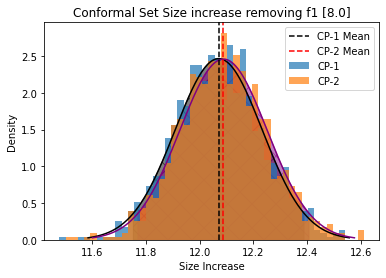

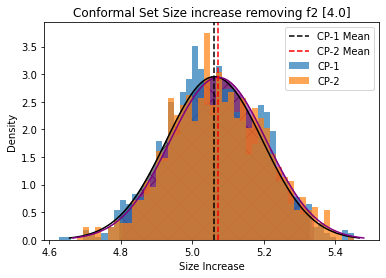

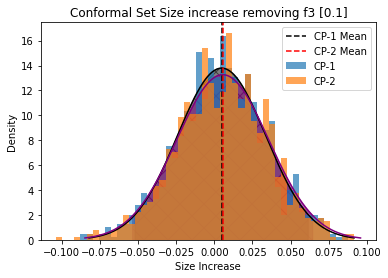

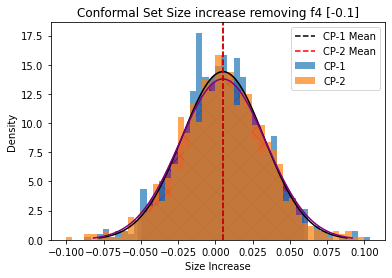

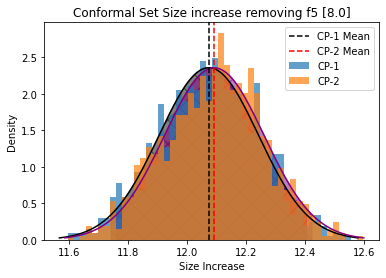

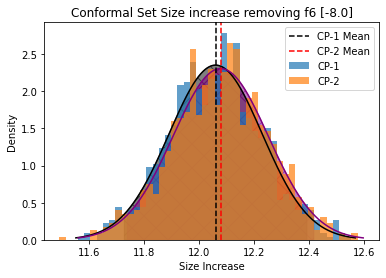

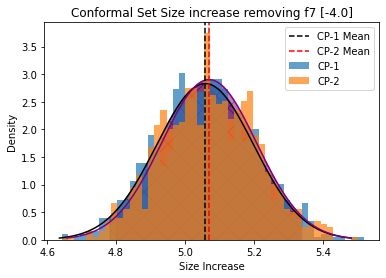

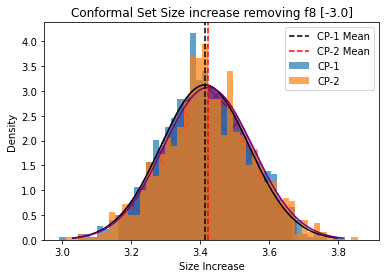

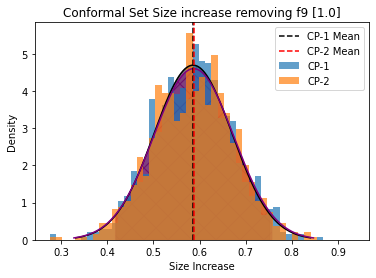

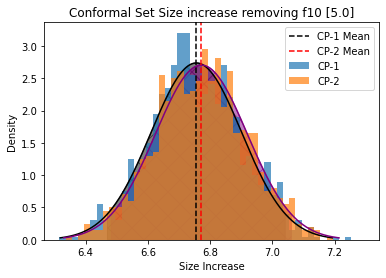

In [50]:
lineardata = LinearData(n=10000, weights=weights)
lineardata.X_y_split(y='Y')

for i, variable in enumerate(lineardata.calib_data_X.columns):

    data_1 = np.array(boot_size_1[variable]) - np.array(boot_size)
    data_2 = np.array(boot_size_2[variable]) - np.array(boot_size)

    # fixed bin size
    bins = np.arange(min(min(data_1), min(data_2)), max(max(data_1), max(data_2)), (max(max(data_1), 
                     max(data_2))-min(min(data_1), min(data_2)))/50) # fixed bin size

    # plt.xlim([min(0, min(data))-5, max(data)+5])
    mean_all = np.mean(np.array(boot_size))
    mean_j_1 = np.mean(np.array(boot_size_1[variable]))
    mean_j_2 = np.mean(np.array(boot_size_2[variable]))
    std_1 = np.std(data_1, ddof=1)
    std_2 = np.std(data_2, ddof=1)
    mean_1 = mean_j_1 - mean_all
    mean_2 = mean_j_2 - mean_all
    h_1 = std_1 * t.ppf((1 + 0.95) / 2., B-1)
    h_2 = std_2 * t.ppf((1 + 0.95) / 2., B-1)
    x_1 = np.linspace(mean_1 - 3*std_1, mean_1 + 3*std_1, 1000)
    x_2 = np.linspace(mean_2 - 3*std_2, mean_2 + 3*std_2, 1000)
    plt.plot(x_1, norm.pdf(x_1, mean_1, std_1), color='black')
    plt.plot(x_2, norm.pdf(x_2, mean_2, std_2), color='purple')
    plt.hist(data_1, bins=bins, alpha=0.7, density=True, label='CP-1')
    plt.hist(data_2, bins=bins, alpha=0.7, density=True, label='CP-2')
    plt.axvline(x=np.mean(data_1), color='black', linestyle='--', label='CP-1 Mean')
    plt.axvline(x=np.mean(data_2), color='red', linestyle='--', label='CP-2 Mean')
    plt.fill_between(
            x= x_1, 
            y1= norm.pdf(x_1, mean_1, std_1), 
            where= (mean_1-h_1 < x_1)&(x_1 < mean_1+h_1),
            hatch='x', alpha=0.5, color='black')
    plt.fill_between(
            x= x_2, 
            y1= norm.pdf(x_2, mean_2, std_2), 
            where= (mean_2-h_2 < x_2)&(x_2 < mean_2+h_2),
            hatch='x', alpha=0.5, color='purple')
    plt.title('Conformal Set Size increase removing ' + variable + ' [' + str(weights[i]) + ']')
    plt.xlabel('Size Increase')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig('images/Linear_data/quantile_conformal_set_size_increase_'+variable)
    plt.show()

In [ ]:
f = open('data_results/Linear_Regression/rf_split_train_twice_IoU.json')
boot_IoU_2 = json.load(f)

f = open('data_results/Linear_Regression/rf_split_train_once_IoU.json')
boot_IoU_1 = json.load(f)

for i, variable in enumerate(lineardata.calib_data_X.columns):

    data_1 = np.array(boot_IoU_1[variable]) / len(lineardata.calib_data_X.columns)
    data_2 = np.array(boot_IoU_2[variable]) / len(lineardata.calib_data_X.columns)

    # fixed bin size
    bins = np.arange(min(data_1), max(data_1), (max(data_1)-min(data_1))/50) # fixed bin size

    plt.hist(data_1, bins=bins, alpha=0.7, density=True, label='CP-1')
    plt.hist(data_2, bins=bins, alpha=0.7, density=True, label='CP-2')
    plt.axvline(x=np.mean(data_1), color='black', linestyle='--', label='CP-1 Mean')
    plt.axvline(x=np.mean(data_2), color='red', linestyle='--', label='CP-2 Mean')
    plt.title('CP-1: IoU removing ' + variable + ' [' + str(weights[i]) + ']')
    plt.xlabel('IoU')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig('images/Linear_data/rf_IoU_'+variable)
    plt.show()

In [66]:
# Let's see if we can find any trend using a linear model which should be easier than in the LOCO Data (which was sinusoidal data)

plot = None
type = 'full'
B = 1000

trend = defaultdict(list) 
y_true_displacement_all = defaultdict(list)
y_true_displacement_j = defaultdict(list)

for i in range(B):
    conformal_predictor = SplitConformal(alpha=0.05)
    lambda_all, model_all = conformal_predictor.calibrate(data_X=lineardata.calib_data_X, data_y=lineardata.calib_data_y, model=LinearRegression(), rand_state=None)
    pred_all = conformal_predictor.predict(lineardata.test_data_X, model=model_all, lambda_conformal=lambda_all)
    cov, size = conformal_predictor.evaluate(pred_all, lineardata.test_data_y)

    for variable in lineardata.calib_data_X.columns:

        conformal_predictor_j = SplitConformal(alpha=0.05)

        if type=='0':
            data_X_j = copy.copy(lineardata.calib_data_X)
            data_X_j[variable] = 0
            data_X_test_j = copy.copy(lineardata.test_data_X)
            data_X_test_j[variable] = 0
        if type=='full':
            data_X_j = copy.copy(lineardata.calib_data_X)
            data_X_j = data_X_j.loc[:, data_X_j.columns!=variable]
            data_X_test_j = copy.copy(lineardata.test_data_X)
            data_X_test_j= data_X_test_j.loc[:, data_X_test_j.columns!=variable]

        lambda_j, model_j = conformal_predictor_j.calibrate(data_X=data_X_j, data_y=lineardata.calib_data_y, model=LinearRegression(), rand_state=None)
        pred_j = conformal_predictor_j.predict(data_X_test_j, model=model_j, lambda_conformal=lambda_j)
        cov_j, size_j = conformal_predictor_j.evaluate(pred_j, lineardata.test_data_y)

        for i in range(len(pred_all)):
            trend[variable].extend([(pred_all[i][1]+pred_all[i][0])/2-(pred_j[i][1]+pred_j[i][0])/2])
            y_true_displacement_all[variable].extend([(pred_all[i][1]+pred_all[i][0])/2-lineardata.test_data_y.iloc[i]])  # If this value is positive it means the true value falls in the lower part of the interval
            y_true_displacement_j[variable].extend([(pred_j[i][1]+pred_j[i][0])/2-lineardata.test_data_y.iloc[i]])  # If this value is positive it means the true value falls in the lower part of the interval

        if plot:
            y_j = pred_j[:plot]
            y_all = pred_all[:plot]
            x = np.array(range(len(y_j)))

            plt.figure(figsize=(12, 8))
            plt.plot((x+0.07,x+0.07),([i for (i,j) in y_all], [j for (i,j) in y_all]),c='black', solid_capstyle='projecting')
            plt.plot((x-0.07,x-0.07),([i for (i,j) in y_j], [j for (i,j) in y_j]),c='red')
            plt.plot(x, lineardata.test_data_y.iloc[:plot].tolist(), 'go')

            red_patch = mpatches.Patch(color='black', label='Conformal Set with ALL Features')
            blue_patch = mpatches.Patch(color='red', label='Conformal Set without ONE Feature')

            plt.xlabel('Test Observation (X_{n+1})')
            plt.ylabel('Conformal Set Interval')
            plt.title('Variable Importance for feature \n ' + variable)
            plt.legend(handles=[red_patch, blue_patch])
            plt.show()

In [ ]:
for i, variable in enumerate(lineardata.calib_data_X.columns):

    plt.hist(trend[variable], density=True, bins=50)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Upper difference ' + variable + ' [' + str(weights[i]) + ']')
    plt.savefig(r'images\Linear_data\trend_'+variable+'.png')
    plt.show()

In [ ]:
plt.hist(y_true_displacement_all[variable], density=True, bins=50)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('True Prediction difference')
plt.savefig(r'images\Linear_data\true_diff.png')
plt.show()

In [ ]:
for i, variable in enumerate(lineardata.calib_data_X.columns):

    plt.hist(y_true_displacement_j[variable], density=True, bins=50)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('True Prediction difference ' + variable + ' [' + str(weights[i]) + ']')
    plt.savefig(r'images\Linear_data\j_true_diff_'+variable+'.png')
    plt.show()

In [ ]:
steps = 0.01
B = 100
model = LinearRegression()
conformal_type = SplitConformal

boot_cov = defaultdict(list)
boot_size = defaultdict(list)
alpha_cov_1 = {}
alpha_cov_2 = {}
alpha_size_1 = {}
alpha_size_2 = {}


for alpha in np.arange(0.01, 1, steps):

    boot_cov_1 = defaultdict(list)
    boot_size_1 = defaultdict(list)
    boot_cov_2 = defaultdict(list)
    boot_size_2 = defaultdict(list)

    print(round(alpha, 2))

    for i in range(B):

        lineardata = LinearData(n=10000, weights=weights)
        lineardata.X_y_split(y='Y')

        pred_all, cov, size, model_trained = aux_funcs.full_conformal(model, data_model=lineardata, conformal_class=conformal_type, alpha=alpha)

        boot_cov[alpha].extend([cov])
        boot_size[alpha].extend([size])

        data_X_train = copy.copy(lineardata.train_data_X)
        data_X_calib = copy.copy(lineardata.calib_data_X)
        data_X_test = copy.copy(lineardata.test_data_X)
        
        for variable in lineardata.calib_data_X.columns:

            # Train Twice
            data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
            data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
            data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

            pred_j_2, cov_j_2, size_j_2 = aux_funcs.train_twice_conformal(model=model, 
                                                                        modified_data={'train': data_X_train_j_2, 'calib': data_X_calib_j_2, 'test': data_X_test_j_2},
                                                                        data_model=lineardata, conformal_class=conformal_type, 
                                                                        alpha=alpha, evaluate=True)
            

            boot_cov_2[variable].extend([cov_j_2])
            boot_size_2[variable].extend([size_j_2])

            # Train Once
            data_X_calib_j_1 = copy.copy(lineardata.calib_data_X)
            data_X_calib_j_1[variable] = 0
            data_X_test_j_1 = copy.copy(lineardata.test_data_X)
            data_X_test_j_1[variable] = 0   

            pred_j_1, cov_j_1, size_j_1 = aux_funcs.train_once_conformal(model=model_trained, 
                                                                        modified_data={'calib': data_X_calib_j_1, 'test': data_X_test_j_1},
                                                                        data_model=lineardata, conformal_class=conformal_type, 
                                                                        alpha=alpha, evaluate=True)


            boot_cov_1[variable].extend([cov_j_1])
            boot_size_1[variable].extend([size_j_1])
    
    alpha_cov_1[alpha] = boot_cov_1
    alpha_cov_2[alpha] = boot_cov_2
    alpha_size_1[alpha] = boot_size_1
    alpha_size_2[alpha] = boot_size_2
    
with open('data_results/Linear_Regression/alpha_grid_full_size.json', 'w') as fp:
    json.dump(boot_cov, fp)

with open('data_results/Linear_Regression/alpha_grid_full_coverage.json', 'w') as fp:
    json.dump(boot_size, fp)

with open('data_results/Linear_Regression/alpha_grid_train_once_coverage.json', 'w') as fp:
    json.dump(alpha_cov_1, fp)

with open('data_results/Linear_Regression/alpha_grid_train_once_size.json', 'w') as fp:
    json.dump(alpha_size_1, fp)

with open('data_results/Linear_Regression/alpha_grid_train_twice_coverage.json', 'w') as fp:
    json.dump(alpha_cov_2, fp)

with open('data_results/Linear_Regression/alpha_grid_train_twice_size.json', 'w') as fp:
    json.dump(alpha_size_2, fp)

In [68]:
f = open('data_results/Linear_Regression/alpha_grid_full_size.json')
boot_cov = json.load(f)

f = open('data_results/Linear_Regression/alpha_grid_full_coverage.json')
boot_size = json.load(f)

f = open('data_results/Linear_Regression/alpha_grid_train_once_coverage.json')
alpha_cov_1 = json.load(f)

f = open('data_results/Linear_Regression/alpha_grid_train_once_size.json')
alpha_size_1 = json.load(f)

f = open('data_results/Linear_Regression/alpha_grid_train_twice_coverage.json')
alpha_cov_2 = json.load(f)

f = open('data_results/Linear_Regression/alpha_grid_train_twice_size.json')
alpha_size_2 = json.load(f)

In [74]:
data_1.append(np.array(alpha_size_1[str(0.01)][variable]).mean() - np.array(boot_size[str(0.01)]).mean())

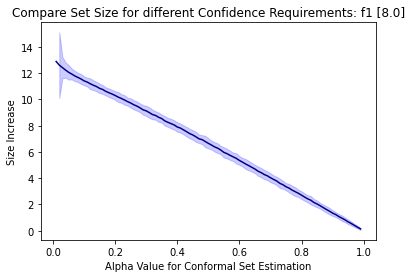

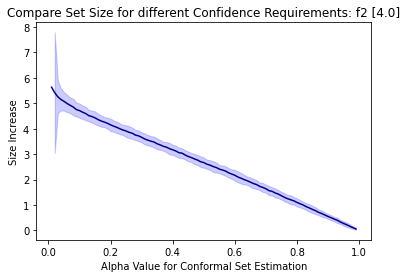

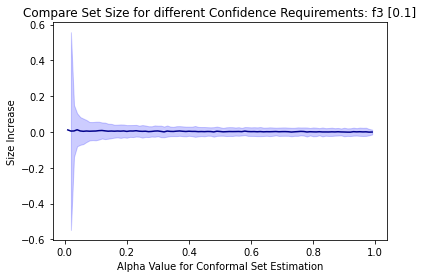

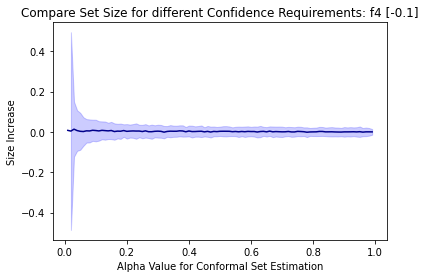

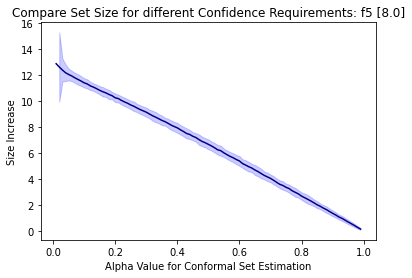

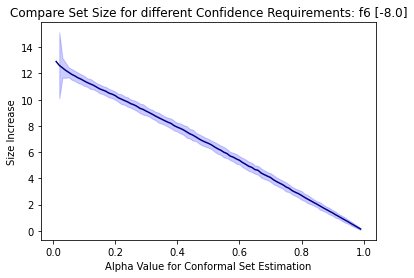

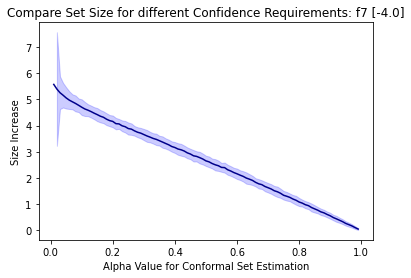

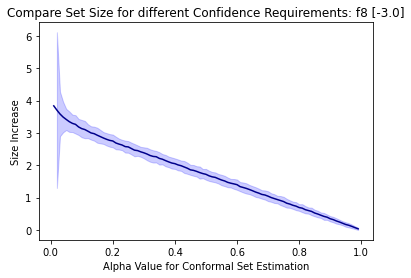

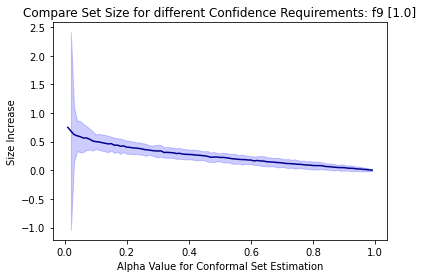

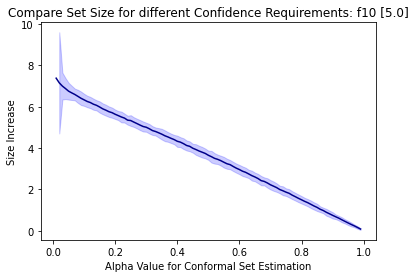

In [81]:
steps = 0.01
for i, variable in enumerate(lineardata.calib_data_X.columns):
# for i, variable in enumerate(['f1']):
    data_1 = []
    ci_1 = []
    for alpha in np.arange(0.01, 1, steps):

        data_1.append(np.array(alpha_size_1[str(alpha)][variable]).mean() - np.array(boot_size[str(alpha)]).mean())
        std_1 = np.std(np.array(alpha_size_1[str(alpha)][variable]) - np.array(boot_size[str(alpha)]), ddof=1)
        ci_1.append(std_1 * t.ppf((1 + 0.95) / 2., len(data_1)-1))

    plt.plot(np.arange(0.01, 1, steps), data_1, 'darkblue', label='CP-1')
    plt.fill_between(np.arange(0.01, 1, steps), (np.array(data_1)-np.array(ci_1)), (np.array(data_1)+np.array(ci_1)), color='blue', alpha=.2)
    plt.ylabel('Size Increase')
    plt.xlabel('Alpha Value for Conformal Set Estimation')
    plt.title('Compare Set Size for different Confidence Requirements: ' + variable + ' [' + str(weights[i]) + ']')
    plt.savefig('images/Linear_data/train_once_alpha_grid_' + variable)
    plt.show()

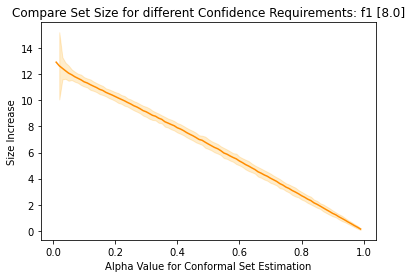

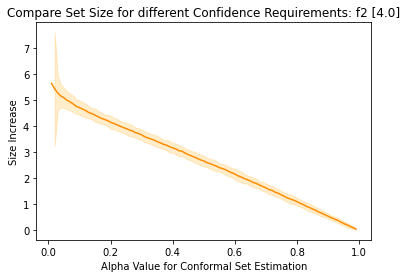

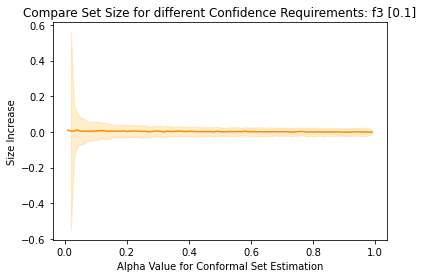

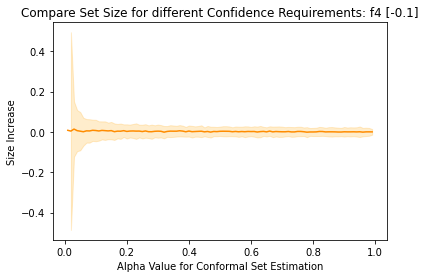

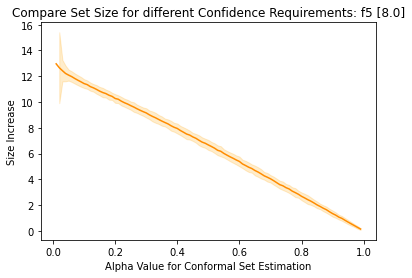

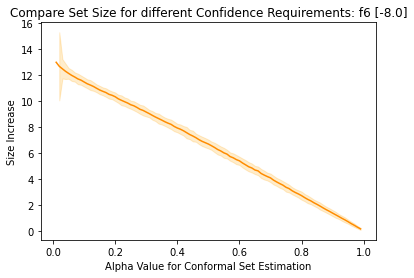

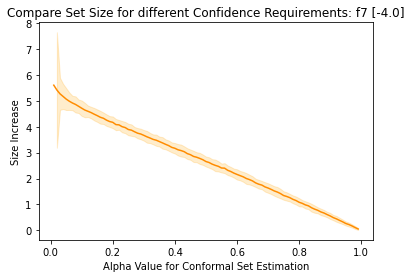

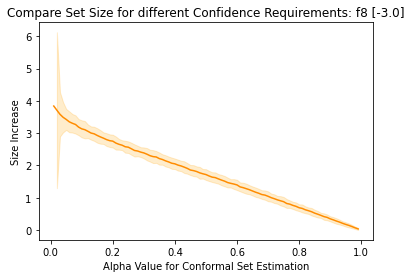

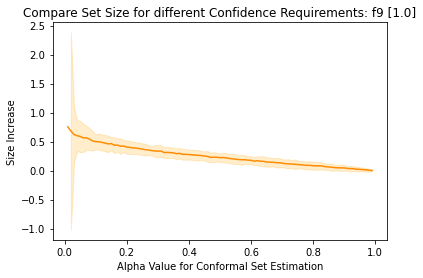

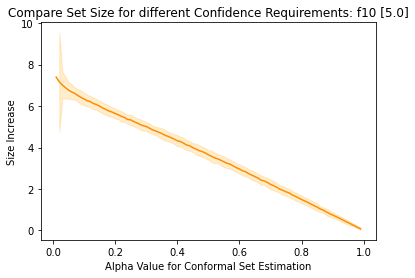

In [82]:
for i, variable in enumerate(lineardata.calib_data_X.columns):
    data_2 = []
    ci_2 = []
    for alpha in np.arange(0.01, 1, steps):

        data_2.append(np.array(alpha_size_2[str(alpha)][variable]).mean() - np.array(boot_size[str(alpha)]).mean())
        std_2 = np.std(np.array(alpha_size_2[str(alpha)][variable]) - np.array(boot_size[str(alpha)]), ddof=1)

        ci_2.append(std_2 * t.ppf((1 + 0.95) / 2., len(data_2)-1))

    plt.plot(np.arange(0.01, 1, steps), data_2, 'darkorange', label='CP-2')
    plt.fill_between(np.arange(0.01, 1, steps), (np.array(data_2)-np.array(ci_2)), (np.array(data_2)+np.array(ci_2)), color='orange', alpha=.2)
    plt.ylabel('Size Increase')
    plt.xlabel('Alpha Value for Conformal Set Estimation')
    plt.title('Compare Set Size for different Confidence Requirements: ' + variable + ' [' + str(weights[i]) + ']')
    plt.savefig('images/Linear_data/train_twice_alpha_grid_' + variable)
    plt.show()

### Alpha grid constant data-generating process

0


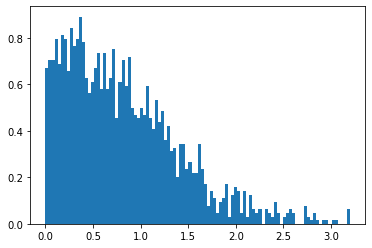

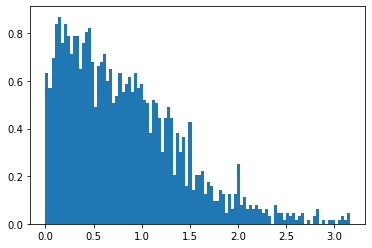

In [168]:
weights=np.array([8, 4, 0.1, -0.1, 8, -8, -4, -3, 1, 5])

steps = 0.01
B = 1
model = LinearRegression()
conformal_type = SplitConformal

alpha_size = {}
alpha_size_1 = {}
alpha_size_2 = {}


for i in range(B):

    lineardata = LinearData(n=10000, weights=weights)
    lineardata.X_y_split(y='Y')

    boot_size = []
    boot_size_1 = defaultdict(list)
    boot_size_2 = defaultdict(list)
    print(i)

    model_all = model
    model_all.fit(lineardata.train_data_X, lineardata.train_data_y)
    model_all = copy.copy(model_all)

    res_all = abs(lineardata.calib_data_y - model_all.predict(lineardata.calib_data_X))

    plt.hist(res_all, bins=100, density=True)
    plt.show()

    # for alpha in [0.05]:
    for alpha in np.arange(0.01, 1, steps):

        # pred_all, cov, size, model_trained = aux_funcs.full_conformal(model, data_model=lineardata, conformal_class=conformal_type, alpha=alpha)
        conformal_predictor = conformal_type(alpha=alpha)
        size = conformal_predictor.calibrate(data_X=lineardata.calib_data_X, data_y=lineardata.calib_data_y, 
                                             model=model_all, rand_state=None)

        boot_size.append(2*size)

        data_X_train = copy.copy(lineardata.train_data_X)
        data_X_calib = copy.copy(lineardata.calib_data_X)
        data_X_test = copy.copy(lineardata.test_data_X)
        
        for variable in ['f3']:
        # for variable in lineardata.calib_data_X.columns:

            # Train Twice
            data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
            data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
            data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

            pred_j_2, cov_j_2, size_j_2 = aux_funcs.train_twice_conformal(model=model, 
                                                                        modified_data={'train': data_X_train_j_2, 'calib': data_X_calib_j_2, 'test': data_X_test_j_2},
                                                                        data_model=lineardata, conformal_class=conformal_type, 
                                                                        alpha=alpha, evaluate=True)
            
            boot_size_2[variable].extend([size_j_2])

            # Train Once
            data_X_calib_j_1 = copy.copy(lineardata.calib_data_X)
            data_X_calib_j_1[variable] = 0
            data_X_test_j_1 = copy.copy(lineardata.test_data_X)
            data_X_test_j_1[variable] = 0   

            pred_j_1, cov_j_1, size_j_1 = aux_funcs.train_once_conformal(model=model_all, 
                                                                        modified_data={'calib': data_X_calib_j_1, 'test': data_X_test_j_1},
                                                                        data_model=lineardata, conformal_class=conformal_type, 
                                                                        alpha=alpha, evaluate=True)

            boot_size_1[variable].extend([size_j_1])
        
    res_j = abs(lineardata.calib_data_y - model_all.predict(data_X_calib_j_1))
    
    plt.hist(res_j, bins=100, density=True)
    plt.show()
    
    alpha_size[i] = boot_size
    alpha_size_1[i] = boot_size_1
    alpha_size_2[i] = boot_size_2

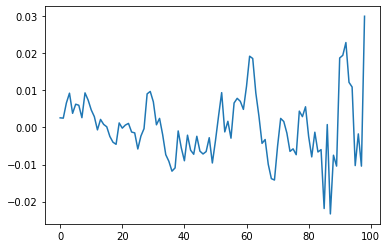

In [174]:
plt.plot(tt)

In [ ]:
tt = []

for alpha in np.arange(0.01, 1, steps):
    print(np.quantile(res_all, q=alpha))
    print(np.quantile(res_j, q=alpha))
    tt.append(np.quantile(res_j, q=alpha)-np.quantile(res_all, q=alpha))
    print((np.quantile(res_j, q=alpha)-np.quantile(res_all, q=alpha)) - (np.quantile(res_j, q=alpha-steps)-np.quantile(res_all, q=alpha-steps)))
    print('===================')

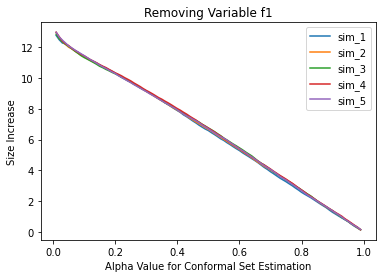

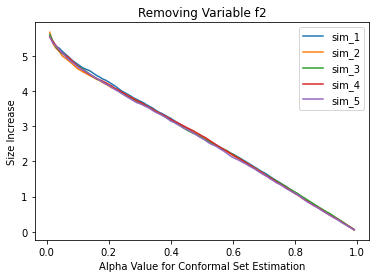

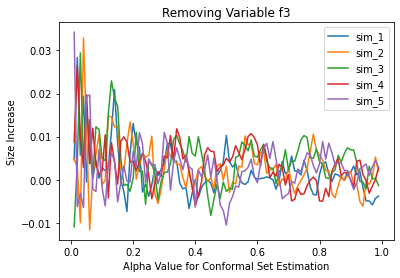

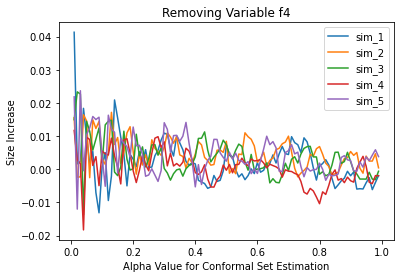

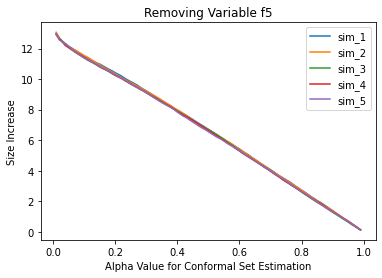

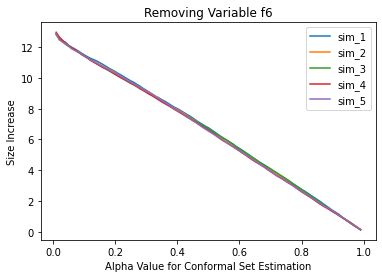

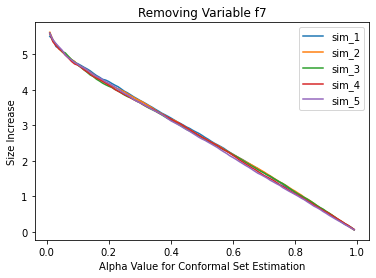

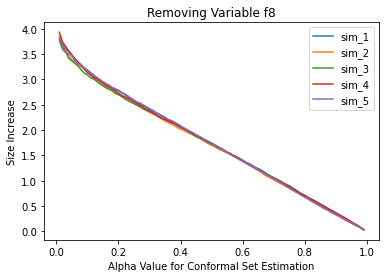

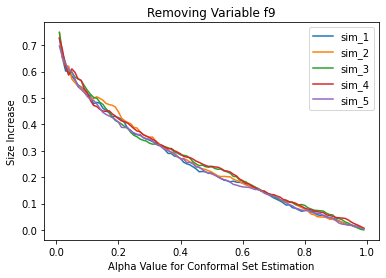

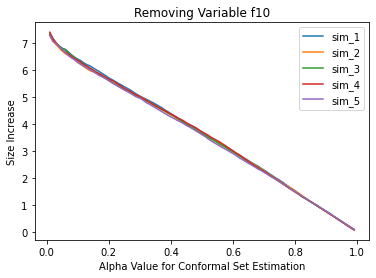

In [165]:
for i, variable in enumerate(lineardata.calib_data_X.columns):
    for j in range(B):
        data = np.array(alpha_size_1[j][variable]) - np.array(alpha_size[j])
        plt.plot(np.arange(0.01, 1, steps), data, label='sim_'+str(j+1))
    plt.title('Removing Variable ' + variable)
    plt.xlabel('Alpha Value for Conformal Set Estimation')
    plt.ylabel('Size Increase')
    plt.legend()
    plt.savefig('images/Linear_data/10000_obs_new_10_paths_alpha_grid_' + variable)
    plt.show()

### Alpha Grid Using a Bootstrap Approach

In [ ]:
steps = 0.01
B = 100
model = LinearRegression()
conformal_type = SplitConformal

lineardata = LinearData(n=10000, weights=weights)
lineardata.X_y_split(y='Y')

vars_j_1 = defaultdict(list)
vars_j_2 = defaultdict(list)
boot_cov = defaultdict(list)
boot_size = defaultdict(list)
alpha_cov_1 = {}
alpha_cov_2 = {}
alpha_size_1 = {}
alpha_size_2 = {}

for alpha in np.arange(0.01, 1, steps):

    model_full = model
    model_full.fit(lineardata.train_data_X, lineardata.train_data_y)
    model_full = copy.copy(model_full)

    conformal_predictor = conformal_type(alpha=alpha)
    lambda_all = conformal_predictor.calibrate(data_X=lineardata.calib_data_X, data_y=lineardata.calib_data_y, 
                                                            model=model_full, rand_state=None)
    pred_all = conformal_predictor.predict(lineardata.test_data_X, model=model_full, lambda_conformal=lambda_all)

    cov, size = conformal_predictor.evaluate(pred_all, lineardata.test_data_y)

    data_X_train = copy.copy(lineardata.train_data_X)
    data_X_calib = copy.copy(lineardata.calib_data_X)
    data_X_test = copy.copy(lineardata.test_data_X)

    for variable in lineardata.calib_data_X.columns:

        # Train Twice
        data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
        data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
        data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

        model_j_2 = model
        model_j_2.fit(data_X_train_j_2, lineardata.train_data_y)

        conformal_predictor_j = SplitConformal(alpha=alpha)

        lambda_j_2 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_2, data_y=lineardata.calib_data_y, 
                                                        model=model_j_2, rand_state=None)
        pred_j_2 = conformal_predictor_j.predict(data_X_test_j_2, model=model_j_2, lambda_conformal=lambda_j_2)

        cov_j_2, size_j_2 = conformal_predictor_j.evaluate(pred_j_2, lineardata.test_data_y)
        vars_j_2[variable].extend([size_j_2-size])

        # Train Once
        data_X_calib_j_1 = copy.copy(data_X_calib)
        data_X_calib_j_1[variable] = 0
        data_X_test_j_1 = copy.copy(data_X_test)
        data_X_test_j_1[variable] = 0   

        conformal_predictor_j = SplitConformal(alpha=alpha)

        lambda_j_1 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_1, data_y=lineardata.calib_data_y, 
                                                        model=model_full, rand_state=None)
        pred_j_1 = conformal_predictor_j.predict(data_X_test_j_1, model=model_full, lambda_conformal=lambda_j_1)

        cov_j_1, size_j_1 = conformal_predictor_j.evaluate(pred_j_1, lineardata.test_data_y)
        vars_j_1[variable].extend([size_j_1-size])


for alpha in np.arange(0.01, 1, steps):

    boot_cov_1 = defaultdict(list)
    boot_size_1 = defaultdict(list)
    boot_cov_2 = defaultdict(list)
    boot_size_2 = defaultdict(list)

    print(round(alpha, 2))

    for i in range(B):

        train_rand = np.random.choice(np.arange(0, len(lineardata.train_data)), size=len(lineardata.train_data), replace=True)
        calib_rand = np.random.choice(np.arange(0, len(lineardata.calib_data)),size=len(lineardata.calib_data), replace=True)

        train_data_X = copy.copy(lineardata.train_data_X.iloc[train_rand])
        train_data_y = copy.copy(lineardata.train_data_y.iloc[train_rand])
        calib_data_X = copy.copy(lineardata.calib_data_X.iloc[calib_rand])
        calib_data_y = copy.copy(lineardata.calib_data_y.iloc[calib_rand])


        model_full = model
        model_full.fit(train_data_X, train_data_y)
        model_full = copy.copy(model_full)

        conformal_predictor = conformal_type(alpha=alpha)
        lambda_all = conformal_predictor.calibrate(data_X=calib_data_X, data_y=calib_data_y, 
                                                                model=model_full, rand_state=None)
        pred_all = conformal_predictor.predict(lineardata.test_data_X, model=model_full, lambda_conformal=lambda_all)

        cov, size = conformal_predictor.evaluate(pred_all, lineardata.test_data_y)

        boot_cov[alpha].extend([cov])
        boot_size[alpha].extend([size])

        data_X_train = copy.copy(train_data_X)
        data_X_calib = copy.copy(calib_data_X)
        data_X_test = copy.copy(lineardata.test_data_X)
        
        for variable in lineardata.calib_data_X.columns:

            # Train Twice
            data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
            data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
            data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

            model_j_2 = model
            model_j_2.fit(data_X_train_j_2, train_data_y)

            conformal_predictor_j = SplitConformal(alpha=alpha)

            lambda_j_2 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_2, data_y=calib_data_y, 
                                                        model=model_j_2, rand_state=None)
            pred_j_2 = conformal_predictor_j.predict(data_X_test_j_2, model=model_j_2, lambda_conformal=lambda_j_2)

            cov_j_2, size_j_2 = conformal_predictor_j.evaluate(pred_j_2, lineardata.test_data_y)
            

            boot_cov_2[variable].extend([cov_j_2])
            boot_size_2[variable].extend([size_j_2])

            # Train Once
            data_X_calib_j_1 = copy.copy(lineardata.calib_data_X)
            data_X_calib_j_1[variable] = 0
            data_X_test_j_1 = copy.copy(lineardata.test_data_X)
            data_X_test_j_1[variable] = 0   

            conformal_predictor_j = SplitConformal(alpha=alpha)

            lambda_j_1 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_1, data_y=calib_data_y, 
                                                        model=model_full, rand_state=None)
            pred_j_1 = conformal_predictor_j.predict(data_X_test_j_1, model=model_full, lambda_conformal=lambda_j_1)

            cov_j_1, size_j_1 = conformal_predictor_j.evaluate(pred_j_1, lineardata.test_data_y)


            boot_cov_1[variable].extend([cov_j_1])
            boot_size_1[variable].extend([size_j_1])
    
    alpha_cov_1[alpha] = boot_cov_1
    alpha_cov_2[alpha] = boot_cov_2
    alpha_size_1[alpha] = boot_size_1
    alpha_size_2[alpha] = boot_size_2
    
with open('data_results/Linear_Regression/boot_alpha_grid_full_size.json', 'w') as fp:
    json.dump(boot_cov, fp)

with open('data_results/Linear_Regression/boot_alpha_grid_full_coverage.json', 'w') as fp:
    json.dump(boot_size, fp)

with open('data_results/Linear_Regression/boot_alpha_grid_train_once_coverage.json', 'w') as fp:
    json.dump(alpha_cov_1, fp)

with open('data_results/Linear_Regression/boot_alpha_grid_train_once_size.json', 'w') as fp:
    json.dump(alpha_size_1, fp)

with open('data_results/Linear_Regression/boot_alpha_grid_train_twice_coverage.json', 'w') as fp:
    json.dump(alpha_cov_2, fp)

with open('data_results/Linear_Regression/boot_alpha_grid_train_twice_size.json', 'w') as fp:
    json.dump(alpha_size_2, fp)

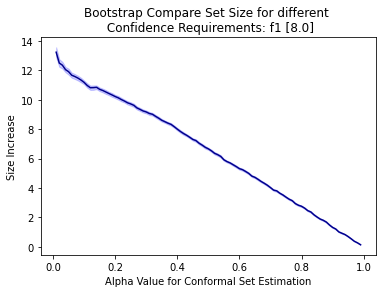

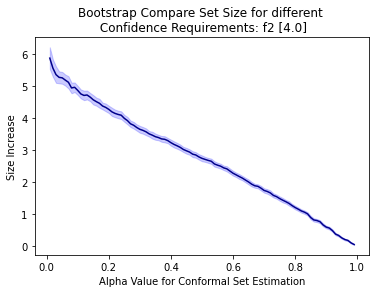

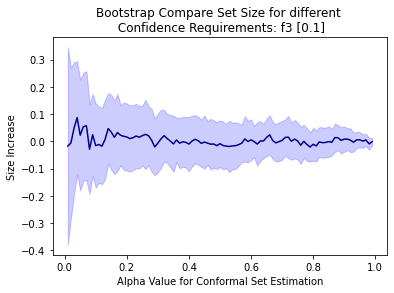

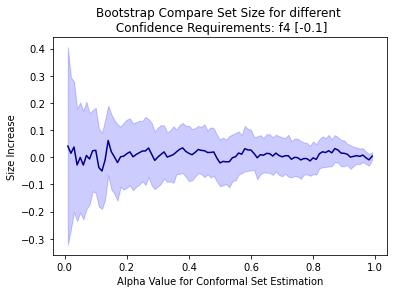

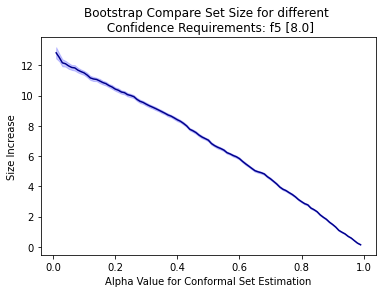

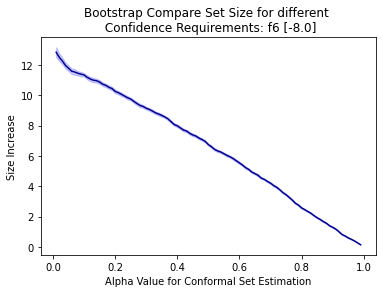

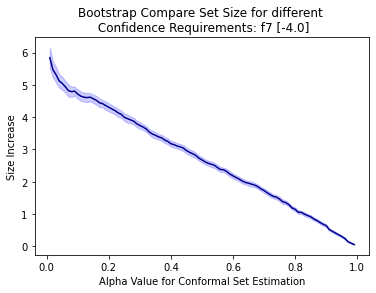

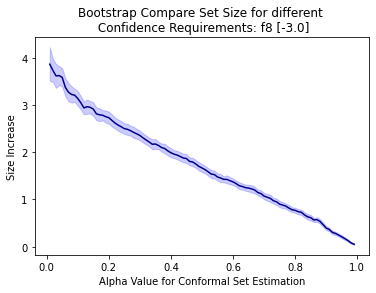

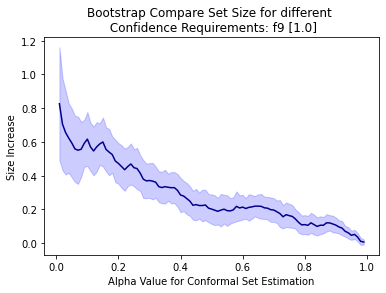

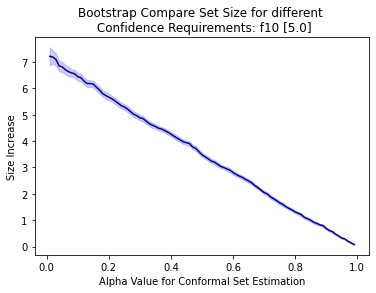

In [119]:
for i, variable in enumerate(lineardata.calib_data_X.columns):
    data_1 = []
    ci_1 = []
    for alpha in np.arange(0.01, 1, steps):

        data_1.append(np.array(alpha_size_1[alpha][variable]).mean() - np.array(boot_size[alpha]).mean())

        ci_1.append(1.96*np.std(np.array(alpha_size_1[alpha][variable]))/np.sqrt(len(alpha_size_1[alpha][variable])))

    plt.plot(np.arange(0.01, 1, steps), vars_j_1[variable], 'darkblue', label='CP-1')
    plt.fill_between(np.arange(0.01, 1, steps), (np.array(vars_j_1[variable])-np.array(ci_1)), 
                    (np.array(vars_j_1[variable])+np.array(ci_1)), color='blue', alpha=.2)
    plt.ylabel('Size Increase')
    plt.xlabel('Alpha Value for Conformal Set Estimation')
    plt.title('Bootstrap Compare Set Size for different \n Confidence Requirements: ' + variable + ' [' + str(weights[i]) + ']')
    plt.savefig('images/Linear_data/boot_alpha_grid_' + variable)
    plt.show()

### We will now look at how our method behaves when we have correlated data

In [23]:
import numpy as np
import matplotlib.pyplot as plt

weights=np.array([8, 4, 0.1, -0.1, 8, -8, -4, -3, 1, 5])

num_samples = 10000
mu = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
cov_matrix = np.array([[1., 0., 0., 0., 1, 1, 0., 0., 0., 0.],
                        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
                        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
                        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
                        [1, 0., 0., 0., 1., 1, 0., 0., 0., 0.],
                        [1, 0., 0., 0., 1, 1., 0., 0., 0., 0.],
                        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
                        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
                        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
                        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

lineardatacorr = LinearDataCorrelated(n=num_samples, mu=mu, cov_matrix=cov_matrix, std=1, weights=weights)
lineardatacorr.X_y_split(y='Y')


In [6]:
weights=np.array([8, 4, 0.1, -0.1, 8, -8, -4, -3, 1, 5])

num_samples = 10000
mu = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
cov_matrix = np.eye(N=10)

lineardatacorr = LinearDataCorrelated(n=num_samples, mu=mu, cov_matrix=cov_matrix, std=1, weights=weights)
lineardatacorr.X_y_split(y='Y')

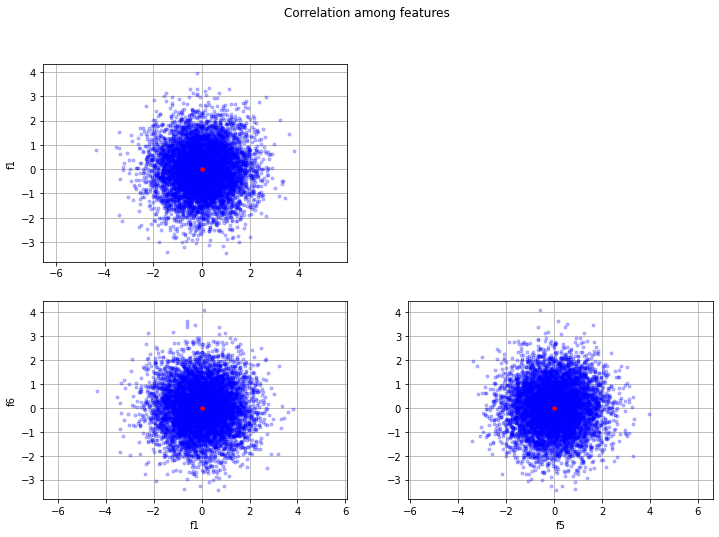

In [7]:
# Plot various projections of the samples.
fig = plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.plot(lineardatacorr.train_data_X['f1'], lineardatacorr.train_data_X['f5'], 'b.', alpha=0.25)
plt.plot(mu[0], mu[4], 'ro', ms=3.5)
plt.ylabel('f1')
plt.axis('equal')
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(lineardatacorr.train_data_X['f1'], lineardatacorr.train_data_X['f6'], 'b.', alpha=0.25)
plt.plot(mu[0], mu[5], 'ro', ms=3.5)
plt.xlabel('f1')
plt.ylabel('f6')
plt.axis('equal')
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(lineardatacorr.train_data_X['f5'], lineardatacorr.train_data_X['f6'], 'b.', alpha=0.25)
plt.plot(mu[4], mu[5], 'ro', ms=3.5)
plt.xlabel('f5')
plt.axis('equal')
plt.grid(True)
plt.suptitle('Correlation among features')

plt.show()

In [60]:
from sklearn.svm import SVR

weights=np.array([8, 4, 0.1, -0.1, 8, -8, -4, -3, 1, 5])

num_samples = 10000
mu = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
cov_matrix = np.eye(N=10)

plot = None
B = 100
model = SVR(kernel='linear')
conformal_type = SplitConformal
alpha = 0.05

boot_cov = []
boot_size = []
boot_cov_1 = defaultdict(list)
boot_size_1 = defaultdict(list)
boot_cov_2 = defaultdict(list)
boot_size_2 = defaultdict(list)

for i in range(B):

    if i % 50 == 0:
        print(i)

    lineardatacorr = LinearDataCorrelated(n=num_samples, mu=mu, cov_matrix=cov_matrix, std=1, weights=weights)
    lineardatacorr.X_y_split(y='Y')

    pred_all, cov, size, model_trained = aux_funcs.full_conformal(model, data_model=lineardatacorr, conformal_class=conformal_type, alpha=alpha)

    boot_cov.append(cov)
    boot_size.append(size)

    data_X_train = copy.copy(lineardatacorr.train_data_X)
    data_X_calib = copy.copy(lineardatacorr.calib_data_X)
    data_X_test = copy.copy(lineardatacorr.test_data_X)
    
    for variable in lineardatacorr.calib_data_X.columns:
    # for variable in ['f1']:

        # Train Twice
        data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
        data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
        data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

        pred_j_2, cov_j_2, size_j_2 = aux_funcs.train_twice_conformal(model=model, 
                                                                      modified_data={'train': data_X_train_j_2, 'calib': data_X_calib_j_2, 'test': data_X_test_j_2},
                                                                      data_model=lineardatacorr, conformal_class=conformal_type, 
                                                                      alpha=alpha, evaluate=True)

        boot_cov_2[variable].extend([cov_j_2])
        boot_size_2[variable].extend([size_j_2])

        # Train Once
        data_X_calib_j_1 = copy.copy(lineardatacorr.calib_data_X)
        data_X_calib_j_1[variable] = 0
        data_X_test_j_1 = copy.copy(lineardatacorr.test_data_X)
        data_X_test_j_1[variable] = 0   

        pred_j_1, cov_j_1, size_j_1 = aux_funcs.train_once_conformal(model=model_trained, 
                                                                     modified_data={'calib': data_X_calib_j_1, 'test': data_X_test_j_1},
                                                                     data_model=lineardatacorr, conformal_class=conformal_type, 
                                                                     alpha=alpha, evaluate=True)

        boot_cov_1[variable].extend([cov_j_1])
        boot_size_1[variable].extend([size_j_1])

0
50


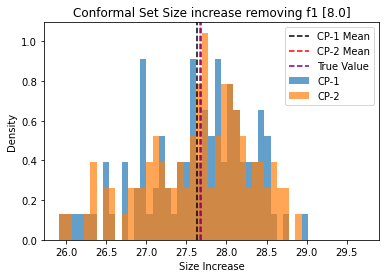

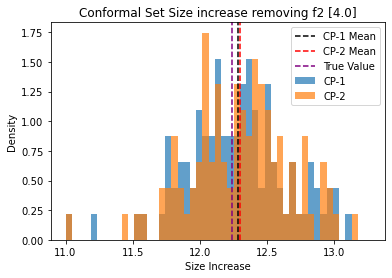

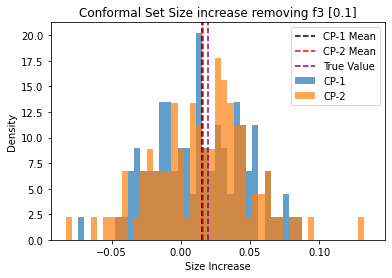

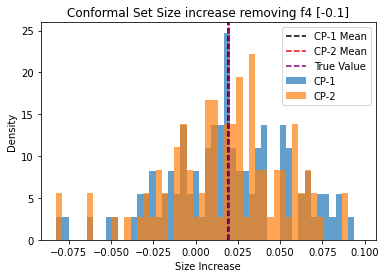

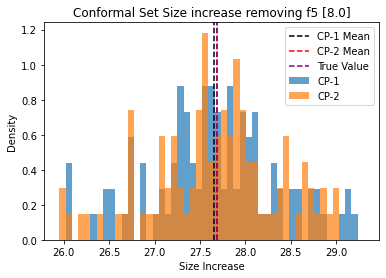

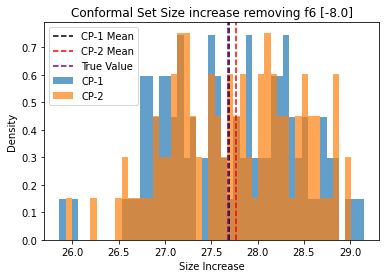

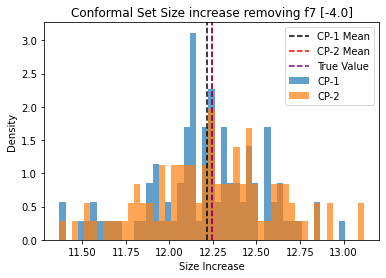

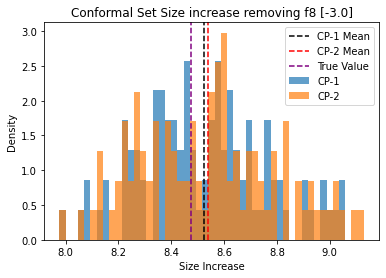

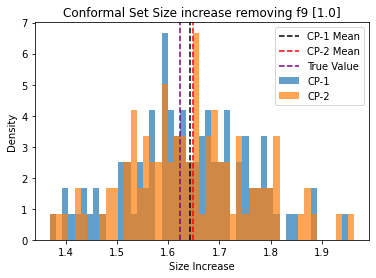

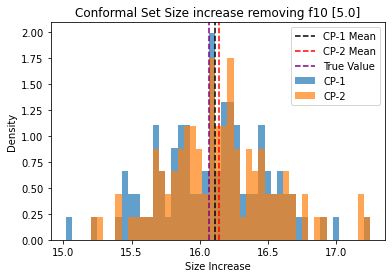

In [61]:
for i, variable in enumerate(lineardata.calib_data_X.columns):

    data_1 = np.array(boot_size_1[variable]) - np.array(boot_size)
    data_2 = np.array(boot_size_2[variable]) - np.array(boot_size)

    # fixed bin size
    bins = np.arange(min(min(data_1), min(data_2)), max(max(data_1), max(data_2)), (max(max(data_1), 
                     max(data_2))-min(min(data_1), min(data_2)))/50) # fixed bin size
    # bins = 50

    # plt.xlim([min(0, min(data))-5, max(data)+5])

    plt.hist(data_1, bins=bins, alpha=0.7, density=True, label='CP-1')
    plt.hist(data_2, bins=bins, alpha=0.7, density=True, label='CP-2')
    plt.axvline(x=np.mean(data_1), color='black', linestyle='--', label='CP-1 Mean')
    plt.axvline(x=np.mean(data_2), color='red', linestyle='--', label='CP-2 Mean')
    plt.axvline(x=foldnorm.ppf(q = 0.95, c = 0, scale = np.sqrt(weights[i]**2 + 1))*2-foldnorm.ppf(q = 0.95, c = 0, scale = 1)*2, 
                color='purple', linestyle='--', label='True Value')
    plt.title('Conformal Set Size increase removing ' + variable + ' [' + str(weights[i]) + ']')
    plt.xlabel('Size Increase')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig('images/Linear_data/true_val_'+variable)
    plt.show()

### Using Quantile Conformal!

In [ ]:
alpha = 0.05
B = 1000
alpha_model = 0.05

boot_cov = []
boot_size = []
boot_cov_1 = defaultdict(list)
boot_size_1 = defaultdict(list)
boot_IoU_1 = defaultdict(list)
boot_cov_2 = defaultdict(list)
boot_size_2 = defaultdict(list)
boot_IoU_2 = defaultdict(list)

string = 'Y ~ f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8 + f9 + f10'

for i in range(B):

    if i % 50 == 0:
        print(i)

    lineardata = LinearData(n=10000, weights=weights)
    lineardata.X_y_split(y='Y')

    quantilereg = smf.quantreg(string, lineardata.train_data)
    fit_lower = quantilereg.fit(q=alpha_model, max_iter=10000)
    fit_upper = quantilereg.fit(q=1-alpha_model, max_iter=10000)

    quantile_conformal = QuantileConformal(alpha=0.05)
    lambda_all = quantile_conformal.calibrate(data_X=lineardata.calib_data_X, data_y=lineardata.calib_data_y, 
                                                model=quantilereg, model_upper=fit_upper, model_lower=fit_lower)
    pred_all = quantile_conformal.predict(data=lineardata.test_data_X, model=quantilereg, model_upper=fit_upper, 
                                            model_lower=fit_lower, lambda_conformal=lambda_all)
    cov_all, size_all = quantile_conformal.evaluate(pred=pred_all, true_data=lineardata.test_data_y, plot=False)

    boot_cov.append(cov_all)
    boot_size.append(size_all)

    data_train = copy.copy(lineardata.train_data)
    data_X_calib = copy.copy(lineardata.calib_data_X)
    data_X_test = copy.copy(lineardata.test_data_X)

    for variable in lineardata.train_data_X.columns:
        if variable == 'f10':
            s = string.replace(' + ' + variable, '')
        else:
            s = string.replace(variable + ' + ', '')

        # Train Twice
        data_X_train_j_2 = data_train.loc[:, data_train.columns!=variable]
        data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
        data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

        quantile_conformal = QuantileConformal(alpha=0.05)

        quantilereg_2 = smf.quantreg(s, data_X_train_j_2)
        fit_lower_2 = quantilereg_2.fit(q=alpha_model, max_iter=10000)
        fit_upper_2 = quantilereg_2.fit(q=1-alpha_model, max_iter=10000)

        lambda_j_2 = quantile_conformal.calibrate(data_X=data_X_calib_j_2, data_y=lineardata.calib_data_y, model=quantilereg_2, 
                                                model_upper=fit_upper_2, model_lower=fit_lower_2)
        pred_j_2 = quantile_conformal.predict(data=data_X_test_j_2, model_upper=fit_upper_2, model=quantilereg_2, 
                                            model_lower=fit_lower_2, lambda_conformal=lambda_j_2)
        cov_j_2, size_j_2 = quantile_conformal.evaluate(pred=pred_j_2, true_data=lineardata.test_data_y, plot=False)

        boot_cov_2[variable].extend([cov_j_2])
        boot_size_2[variable].extend([size_j_2])

        # Train Once
        data_X_calib_j_1 = copy.copy(lineardata.calib_data_X)
        data_X_calib_j_1[variable] = 0
        data_X_test_j_1 = copy.copy(lineardata.test_data_X)
        data_X_test_j_1[variable] = 0       

        lambda_j_1 = quantile_conformal.calibrate(data_X=data_X_calib_j_1, data_y=lineardata.calib_data_y, model=quantilereg, 
                                                model_upper=fit_upper, model_lower=fit_lower)
        pred_j_1 = quantile_conformal.predict(data=data_X_test_j_1, model_upper=fit_upper, model=quantilereg, 
                                            model_lower=fit_lower, lambda_conformal=lambda_j_1)
        cov_j_1, size_j_1 = quantile_conformal.evaluate(pred=pred_j_1, true_data=lineardata.test_data_y, plot=False)

        boot_cov_1[variable].extend([cov_j_1])
        boot_size_1[variable].extend([size_j_1])

In [ ]:
with open('data_results/Linear_Regression/linear_quantile_coverage_full.json', 'w') as fp:
    json.dump(boot_cov, fp)

with open('data_results/Linear_Regression/linear_quantile_size_full.json', 'w') as fp:
    json.dump(boot_size, fp)

with open('data_results/Linear_Regression/linear_quantile_train_once_coverage.json', 'w') as fp:
    json.dump(boot_cov_1, fp)

with open('data_results/Linear_Regression/linear_quantile_train_once_size.json', 'w') as fp:
    json.dump(boot_size_1, fp)

with open('data_results/Linear_Regression/linear_quantile_train_twice_coverage.json', 'w') as fp:
    json.dump(boot_cov_2, fp)

with open('data_results/Linear_Regression/linear_quantile_train_twice_size.json', 'w') as fp:
    json.dump(boot_size_2, fp)

In [ ]:
f = open('data_results/Linear_Regression/linear_quantile_size_full.json')
boot_size = json.load(f)

f = open('data_results/Linear_Regression/linear_quantile_train_twice_size.json')
boot_size_2 = json.load(f)

f = open('data_results/Linear_Regression/linear_quantile_train_once_size.json')
boot_size_1 = json.load(f)

for i, variable in enumerate(lineardata.calib_data_X.columns):

    data_1 = np.array(boot_size_1[variable]) - np.array(boot_size)
    data_2 = np.array(boot_size_2[variable]) - np.array(boot_size)

    # fixed bin size
    bins = np.arange(min(data_1), max(data_1), (max(data_1)-min(data_1))/50) # fixed bin size

    # plt.xlim([min(0, min(data))-5, max(data)+5])

    plt.hist(data_1, bins=bins, alpha=0.7, density=True, label='CP-1')
    plt.hist(data_2, bins=bins, alpha=0.7, density=True, label='CP-2')
    plt.axvline(x=np.mean(data_1), color='black', linestyle='--', label='CP-1 Mean')
    plt.axvline(x=np.mean(data_2), color='red', linestyle='--', label='CP-2 Mean')
    plt.title('Conformal Set Size increase removing ' + variable + ' [' + str(weights[i]) + ']')
    plt.xlabel('Size Increase')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig('images\Linear_data\quantile_conformal_set_size_increase_'+variable)
    plt.show()

In [ ]:
# What happens if we go over different alpha values?
B = 100
weights=np.array([8, 4, 0.5, -0.5, 8, -8, -4, -3, 1, 5])
lineardata = LinearData(n=10000, weights=weights)
lineardata.X_y_split(y='Y')
average_size = defaultdict(list)
ci_dict = {}
alpha_model = 0.05

for j, variable in enumerate(lineardata.calib_data_X.columns):
    print(variable)
    ci = []
    for alpha in np.arange(0.1, 1, 0.01):

        if (round(alpha, 2)*100) % 5 == 0:
            print(alpha)

        temp = 0
        ci_temp = []
        
        cov_all = 0
        for i in range(B):

            weights=np.array([8, 4, 0.5, -0.5, 8, -8, -4, -3, 1, 5])
            lineardata = LinearData(n=10000, weights=weights)
            lineardata.X_y_split(y='Y')

            quantilereg = smf.quantreg('Y ~ f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8 + f9 + f10', lineardata.calib_data)
            fit_lower = quantilereg.fit(q=alpha_model, max_iter=50000)
            fit_upper = quantilereg.fit(q=1-alpha_model, max_iter=50000)

            quantile_conformal = QuantileConformal(alpha=1-alpha)
            lambda_all = quantile_conformal.calibrate(data_X=lineardata.calib_data_X, data_y=lineardata.calib_data_y, model=quantilereg, model_upper=fit_upper, model_lower=fit_lower)
            pred_all = quantile_conformal.predict(data=lineardata.test_data_X, model=quantilereg, model_upper=fit_upper, model_lower=fit_lower, lambda_conformal=lambda_all)
            cov, size_all = quantile_conformal.evaluate(pred=pred_all, true_data=lineardata.test_data_y, plot=False)

            data_X_j = copy.copy(lineardata.calib_data_X)
            data_X_j[variable] = 0
            data_X_test_j = copy.copy(lineardata.test_data_X)
            data_X_test_j[variable] = 0

            lambda_j = quantile_conformal.calibrate(data_X=data_X_j, data_y=lineardata.calib_data_y, model=quantilereg, model_upper=fit_upper, model_lower=fit_lower)
            pred_j = quantile_conformal.predict(data=data_X_test_j, model_upper=fit_upper, model=quantilereg, model_lower=fit_lower, lambda_conformal=lambda_j)
            cov_j, size_j = quantile_conformal.evaluate(pred=pred_j, true_data=lineardata.test_data_y, plot=False)

            temp += size_j-size_all
            ci_temp.append(size_j-size_all)
            cov_all += cov

        average_size[variable].extend([temp/B])
        ci.append(ci_temp)
    ci_dict[variable] = ci

    plt.figure(figsize=(12,8))
    ci = 1.96*np.std(np.array(ci_dict[variable]), axis=1)/np.sqrt(len(ci_dict[variable]))
    plt.plot(np.arange(0.1, 1, 0.01), average_size[variable], 'r')
    plt.fill_between(np.arange(0.1, 1, 0.01), (average_size[variable]-ci), (average_size[variable]+ci), color='b', alpha=.2)
    plt.ylabel('Size Increase')
    plt.xlabel('Alpha Value for Conformal Set Estimation')
    plt.title('Compare Set Size for different Confidence Requirements: ' + variable + ' [' + str(weights[j]) + ']')
    plt.savefig('images/Linear_data/quantile_alpha_grid_' + variable)
    plt.show();

### Let's Review the Bootstrap Approach

In [4]:
from sklearn.svm import SVR

weights=np.array([8, 4, 0.1, -0.1, 8, -8, -4, -3, 1, 5])

plot = None
B = 1000
model = LinearRegression()
conformal_type = SplitConformal
alpha = 0.05

lineardatacorr = LinearData(n=10000, weights=weights)
lineardatacorr.X_y_split(y='Y')

boot_cov = []
boot_size = []
vars_j_1 = []
vars_j_2 = []
boot_cov_1 = defaultdict(list)
boot_size_1 = defaultdict(list)
boot_cov_2 = defaultdict(list)
boot_size_2 = defaultdict(list)

model_full = model
model_full.fit(lineardatacorr.train_data_X, lineardatacorr.train_data_y)
model_full = copy.copy(model_full)

conformal_predictor = conformal_type(alpha=alpha)
lambda_all = conformal_predictor.calibrate(data_X=lineardatacorr.calib_data_X, data_y=lineardatacorr.calib_data_y, 
                                                        model=model_full, rand_state=None)
pred_all = conformal_predictor.predict(lineardatacorr.test_data_X, model=model_full, lambda_conformal=lambda_all)

cov, size = conformal_predictor.evaluate(pred_all, lineardatacorr.test_data_y)

data_X_train = copy.copy(lineardatacorr.train_data_X)
data_X_calib = copy.copy(lineardatacorr.calib_data_X)
data_X_test = copy.copy(lineardatacorr.test_data_X)
    
for variable in lineardatacorr.calib_data_X.columns:

    # Train Twice
    data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
    data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
    data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

    model_j_2 = model
    model_j_2.fit(data_X_train_j_2, lineardatacorr.train_data_y)

    conformal_predictor_j = SplitConformal(alpha=alpha)

    lambda_j_2 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_2, data_y=lineardatacorr.calib_data_y, 
                                                    model=model_j_2, rand_state=None)
    pred_j_2 = conformal_predictor_j.predict(data_X_test_j_2, model=model_j_2, lambda_conformal=lambda_j_2)

    cov_j_2, size_j_2 = conformal_predictor_j.evaluate(pred_j_2, lineardatacorr.test_data_y)
    vars_j_2.append(size_j_2-size)

    # Train Once
    data_X_calib_j_1 = copy.copy(data_X_calib)
    data_X_calib_j_1[variable] = 0
    data_X_test_j_1 = copy.copy(data_X_test)
    data_X_test_j_1[variable] = 0   

    conformal_predictor_j = SplitConformal(alpha=alpha)

    lambda_j_1 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_1, data_y=lineardatacorr.calib_data_y, 
                                                    model=model_full, rand_state=None)
    pred_j_1 = conformal_predictor_j.predict(data_X_test_j_1, model=model_full, lambda_conformal=lambda_j_1)

    cov_j_1, size_j_1 = conformal_predictor_j.evaluate(pred_j_1, lineardatacorr.test_data_y)
    vars_j_1.append(size_j_1-size)

for i in range(B):

    if i % 50 == 0:
        print(i)

    train_rand = np.random.choice(np.arange(0, len(lineardatacorr.train_data)), size=len(lineardatacorr.train_data), replace=True)
    calib_rand = np.random.choice(np.arange(0, len(lineardatacorr.calib_data)),size=len(lineardatacorr.calib_data), replace=True)

    train_data_X = copy.copy(lineardatacorr.train_data_X.iloc[train_rand])
    train_data_y = copy.copy(lineardatacorr.train_data_y.iloc[train_rand])
    calib_data_X = copy.copy(lineardatacorr.calib_data_X.iloc[calib_rand])
    calib_data_y = copy.copy(lineardatacorr.calib_data_y.iloc[calib_rand])

    model_full = model
    model_full.fit(train_data_X, train_data_y)
    model_full = copy.copy(model_full)

    conformal_predictor = conformal_type(alpha=alpha)
    lambda_all = conformal_predictor.calibrate(data_X=calib_data_X, data_y=calib_data_y, 
                                                          model=model_full, rand_state=None)
    pred_all = conformal_predictor.predict(lineardatacorr.test_data_X, model=model_full, lambda_conformal=lambda_all)

    cov, size = conformal_predictor.evaluate(pred_all, lineardatacorr.test_data_y)

    boot_cov.append(cov)
    boot_size.append(size)

    data_X_train = copy.copy(train_data_X)
    data_X_calib = copy.copy(calib_data_X)
    data_X_test = copy.copy(lineardatacorr.test_data_X)
    
    for variable in lineardatacorr.calib_data_X.columns:

        # Train Twice
        data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
        data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
        data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

        model_j_2 = model
        model_j_2.fit(data_X_train_j_2, train_data_y)

        conformal_predictor_j = SplitConformal(alpha=alpha)

        lambda_j_2 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_2, data_y=calib_data_y, 
                                                     model=model_j_2, rand_state=None)
        pred_j_2 = conformal_predictor_j.predict(data_X_test_j_2, model=model_j_2, lambda_conformal=lambda_j_2)

        cov_j_2, size_j_2 = conformal_predictor_j.evaluate(pred_j_2, lineardatacorr.test_data_y)

        boot_cov_2[variable].extend([cov_j_2])
        boot_size_2[variable].extend([size_j_2])

        # Train Once
        data_X_calib_j_1 = copy.copy(data_X_calib)
        data_X_calib_j_1[variable] = 0
        data_X_test_j_1 = copy.copy(data_X_test)
        data_X_test_j_1[variable] = 0   

        conformal_predictor_j = SplitConformal(alpha=alpha)

        lambda_j_1 = conformal_predictor_j.calibrate(data_X=data_X_calib_j_1, data_y=calib_data_y, 
                                                     model=model_full, rand_state=None)
        pred_j_1 = conformal_predictor_j.predict(data_X_test_j_1, model=model_full, lambda_conformal=lambda_j_1)

        cov_j_1, size_j_1 = conformal_predictor_j.evaluate(pred_j_1, lineardatacorr.test_data_y)

        boot_cov_1[variable].extend([cov_j_1])
        boot_size_1[variable].extend([size_j_1])

with open('data_results/Linear_Regression/boot_linear_split_size_full.json', 'w') as fp:
    json.dump(boot_size, fp)

with open('data_results/Linear_Regression/boot_linear_split_train_once_size.json', 'w') as fp:
    json.dump(boot_size_1, fp)

with open('data_results/Linear_Regression/boot_linear_split_train_twice_size.json', 'w') as fp:
    json.dump(boot_size_2, fp)

with open('data_results/Linear_Regression/boot_linear_split_train_twice_var_1_j.json', 'w') as fp:
    json.dump(vars_j_1, fp)

with open('data_results/Linear_Regression/boot_linear_split_train_twice_var_2_j.json', 'w') as fp:
    json.dump(vars_j_2, fp)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


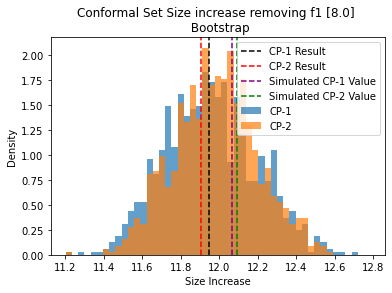

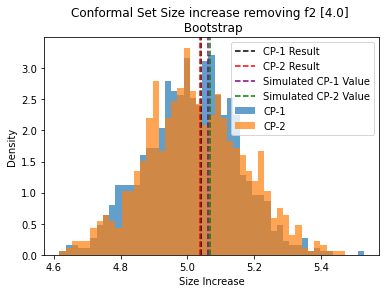

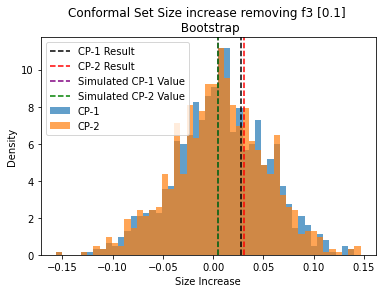

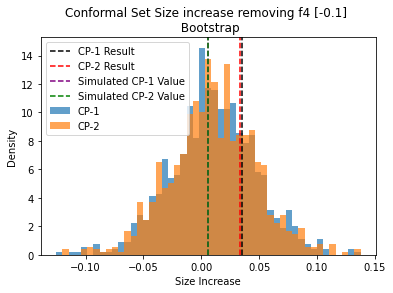

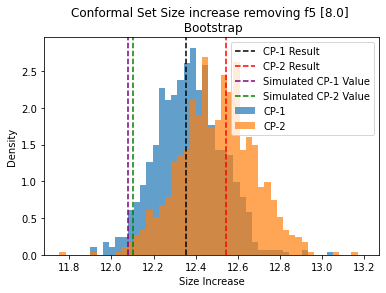

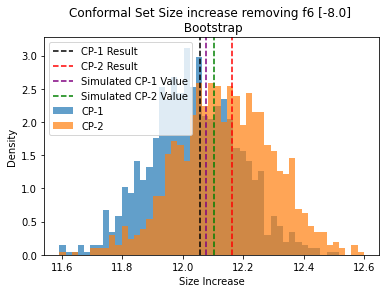

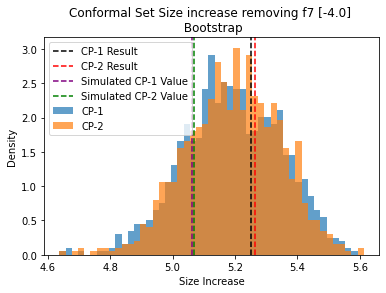

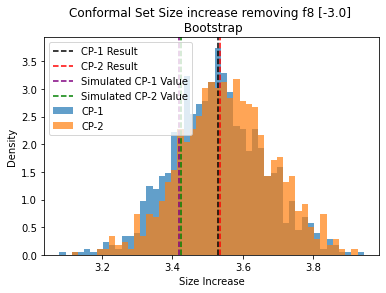

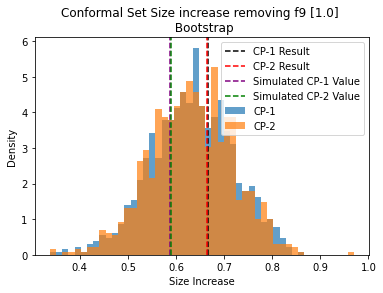

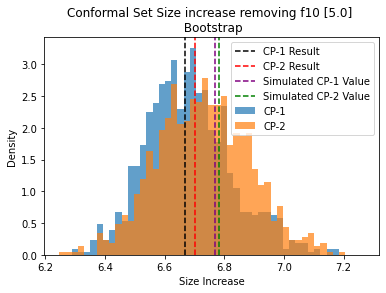

In [7]:
# f = open('data_results/Linear_Regression/linear_split_size_full.json')
# boot_size = json.load(f)

# f = open('data_results/Linear_Regression/linear_split_train_once_size.json')
# boot_size_1 = json.load(f)

# f = open('data_results/Linear_Regression/linear_split_train_twice_size.json')
# boot_size_1 = json.load(f)

f = open('data_results/Linear_Regression/linear_split_size_full.json')
sim_size = json.load(f)

f = open('data_results/Linear_Regression/linear_split_train_once_size.json')
sim_size_1 = json.load(f)

f = open('data_results/Linear_Regression/linear_split_train_twice_size.json')
sim_size_2 = json.load(f)

for i, variable in enumerate(lineardatacorr.calib_data_X.columns):

    data_1 = np.array(boot_size_1[variable]) - np.array(boot_size)
    data_2 = np.array(boot_size_2[variable]) - np.array(boot_size)

    # fixed bin size
    bins = np.arange(min(min(data_1), min(data_2)), max(max(data_1), max(data_2)), (max(max(data_1), 
                     max(data_2))-min(min(data_1), min(data_2)))/50) # fixed bin size
    # bins = 50

    # plt.xlim([min(0, min(data))-5, max(data)+5])

    plt.hist(data_1, bins=bins, alpha=0.7, density=True, label='CP-1')
    plt.hist(data_2, bins=bins, alpha=0.7, density=True, label='CP-2')
    plt.axvline(x=vars_j_1[i], color='black', linestyle='--', label='CP-1 Result')
    plt.axvline(x=vars_j_2[i], color='red', linestyle='--', label='CP-2 Result')
    plt.axvline(x=np.array(sim_size_1[variable]).mean() - np.array(sim_size).mean(), 
                color='purple', linestyle='--', label='Simulated CP-1 Value')
    plt.axvline(x=np.array(sim_size_2[variable]).mean() - np.array(sim_size).mean(), 
                color='green', linestyle='--', label='Simulated CP-2 Value')
    plt.title('Conformal Set Size increase removing ' + variable + ' [' + str(weights[i]) + '] \n Bootstrap')
    plt.xlabel('Size Increase')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig('images/Linear_data/boot_lin_reg_split_'+variable)
    plt.show()

# Trying out different plots

In [65]:
f = open('data_results/Linear_Regression/rf_split_size_full.json')
boot_size = json.load(f)

f = open('data_results/Linear_Regression/rf_split_train_twice_size.json')
boot_size_2 = json.load(f)

f = open('data_results/Linear_Regression/rf_split_train_once_size.json')
boot_size_1 = json.load(f)

In [66]:
from scipy.stats.stats import pearsonr

plot = False

var1 = []
var2 = []
ci_1 = []
ci_2 = []

for i, variable in enumerate(lineardata.calib_data_X.columns):

    data_1 = np.array(boot_size_1[variable]) - np.array(boot_size)
    data_2 = np.array(boot_size_2[variable]) - np.array(boot_size)

    var1.append(np.mean(data_1))
    var2.append(np.mean(data_2))
    
    std_1 = np.std(data_1, ddof=1)
    std_2 = np.std(data_2, ddof=1)

    ci_1.append(std_1 * t.ppf((1 + 0.95) / 2., B-1))
    ci_2.append(std_2 * t.ppf((1 + 0.95) / 2., B-1))

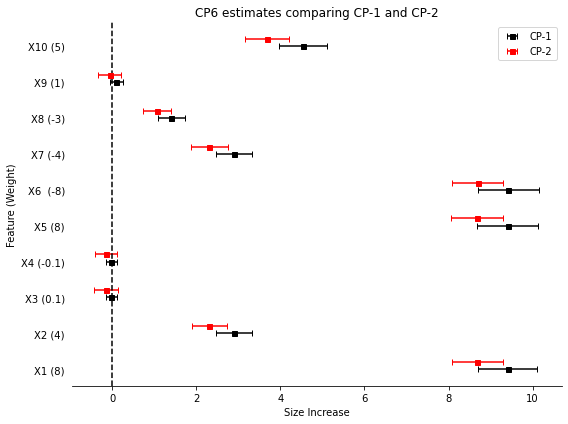

In [67]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8,6))
x_ticks = ("X1 (8)", "X2 (4)", "X3 (0.1)", "X4 (-0.1)", "X5 (8)", "X6  (-8)", "X7 (-4)", "X8 (-3)", "X9 (1)", "X10 (5)")

y_1 = np.arange(1, len(var1)+1)-0.2
y_2 = y_1 + 0.2

x_1 = var1
x_2 = var2

err_1 = ci_1
err_2 = ci_2

plt.errorbar(x=x_1, y=y_1, xerr=err_1, color="black", capsize=3,
             linestyle="None",
             marker="s", markersize=5, mfc="black", mec="black", label='CP-1')

plt.errorbar(x=x_2, y=y_2, xerr=err_2, color="red", capsize=3,
             linestyle="None",
             marker="s", markersize=5, mfc="red", mec="red", label='CP-2')

plt.yticks(y_1, x_ticks)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('CP6 estimates comparing CP-1 and CP-2')
plt.xlabel('Size Increase')
plt.ylabel('Feature (Weight)')
ax.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.tick_params(left = False)
plt.legend()
plt.savefig('images/Linear_data/rf_split_size_increase_summary')
plt.show()

# Model Performance

In [74]:
from data_models.basic import LinearData, LinearDataCorrelated, LinearDataTest

weights=np.array([8, 4, 0.1, -0.1, 8, -8, -4, -3, 1, 5])

num_samples = 10000
mu = 0
std = 0.5

lineardatacorr = LinearDataTest(n=num_samples, mu=mu, std=std, weights=weights)
lineardatacorr.X_y_split(y='Y')

In [75]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import itertools

regressor = LinearRegression()

regressor.fit(X=lineardatacorr.train_data_X, y=lineardatacorr.train_data_y)

train_pred = regressor.predict(X=lineardatacorr.train_data_X)
calib_pred = regressor.predict(X=lineardatacorr.calib_data_X)
test_pred = regressor.predict(X=lineardatacorr.test_data_X)

train_mse = mean_squared_error(lineardatacorr.train_data_y, train_pred)
calib_mse = mean_squared_error(lineardatacorr.calib_data_y, calib_pred)
test_mse = mean_squared_error(lineardatacorr.test_data_y, test_pred)

print('Linear Train: ', train_mse)
print('Linear Calibration: ', calib_mse)
print('Linear Test: ', test_mse)
print('=====================')

# params = [[50, 75, 100],[5, 10, 20, 40, None], [2, 3, 4, 10]]
params = [[50],[20], [2]]
# params = [[10],[10]]
min_ = 1000
for param in list(itertools.product(*params)):

    print(param)

    regressor = RandomForestRegressor(n_estimators=param[0], max_depth=param[1], min_samples_split=param[2])
    # regressor = DecisionTreeRegressor(max_depth=param[0], min_samples_split=param[1], min_samples_leaf=param[2], max_features=param[3])

    regressor.fit(X=lineardatacorr.train_data_X, y=lineardatacorr.train_data_y)

    train_pred = regressor.predict(X=lineardatacorr.train_data_X)
    calib_pred = regressor.predict(X=lineardatacorr.calib_data_X)
    test_pred = regressor.predict(X=lineardatacorr.test_data_X)

    train_mse = mean_squared_error(lineardatacorr.train_data_y, train_pred)
    calib_mse = mean_squared_error(lineardatacorr.calib_data_y, calib_pred)
    test_mse = mean_squared_error(lineardatacorr.test_data_y, test_pred)

    print('RF Train: ', train_mse)
    print('RF Calibration: ', calib_mse)
    print('RF Test: ', test_mse)
    print('=====================')

    if test_mse < min_:
        min_ = test_mse
        best = param


Linear Train:  0.2490350097497422
Linear Calibration:  0.24533162875006556
Linear Test:  0.23930232788850156
(50, 20, 2)
RF Train:  0.9001569046834678
RF Calibration:  6.196002225708522
RF Test:  5.475264964679088


In [71]:
print(best)
print(min_)

(75, 20, 2)
5.34397319040594


In [89]:
from sklearn.svm import SVR
std=0.5
# weights=np.array([8, 4, 0.1, -0.1, 8, -8, -4, -3, 1, 5])
weights=np.array([8, 4, 0.1, -3, 5])

# num_samples = 10000
mu = np.array([0, 0, 0, 0, 0, 
            #    0, 0, 0, 0, 0
              ])
cov_matrix = np.eye(N=len(weights))*std**2

num_samples = 100000

plot = None
B = 500
model = RandomForestRegressor(n_estimators=50, max_depth=20, min_samples_split=2)
# model = LinearRegression()
conformal_type = SplitConformal
alpha = 0.05

boot_cov = []
boot_size = []
boot_cov_1 = defaultdict(list)
boot_size_1 = defaultdict(list)
boot_cov_2 = defaultdict(list)
boot_size_2 = defaultdict(list)

for i in range(B):

    lineardatacorr = LinearDataCorrelated(n=num_samples, mu=mu, cov_matrix=cov_matrix, std=std, weights=weights)
    lineardatacorr.X_y_split(y='Y')

    pred_all, cov, size, model_trained = aux_funcs.full_conformal(model, data_model=lineardatacorr, conformal_class=conformal_type, alpha=alpha)

    if i % 1 == 0:
        print(i)
        train_pred = model_trained.predict(X=lineardatacorr.train_data_X)
        calib_pred = model_trained.predict(X=lineardatacorr.calib_data_X)
        test_pred = model_trained.predict(X=lineardatacorr.test_data_X)

        train_mse = mean_squared_error(lineardatacorr.train_data_y, train_pred)
        calib_mse = mean_squared_error(lineardatacorr.calib_data_y, calib_pred)
        test_mse = mean_squared_error(lineardatacorr.test_data_y, test_pred)

        print('Linear Train: ', train_mse)
        print('Linear Calibration: ', calib_mse)
        print('Linear Test: ', test_mse)
        print('=====================')
        

    boot_cov.append(cov)
    boot_size.append(size)

    data_X_train = copy.copy(lineardatacorr.train_data_X)
    data_X_calib = copy.copy(lineardatacorr.calib_data_X)
    data_X_test = copy.copy(lineardatacorr.test_data_X)
    
    for variable in lineardatacorr.calib_data_X.columns:
    # for variable in ['f1']:

        # Train Twice
        data_X_train_j_2 = data_X_train.loc[:, data_X_train.columns!=variable]
        data_X_calib_j_2 = data_X_calib.loc[:, data_X_calib.columns!=variable]
        data_X_test_j_2 = data_X_test.loc[:, data_X_test.columns!=variable]

        pred_j_2, cov_j_2, size_j_2 = aux_funcs.train_twice_conformal(model=model, 
                                                                      modified_data={'train': data_X_train_j_2, 'calib': data_X_calib_j_2, 'test': data_X_test_j_2},
                                                                      data_model=lineardatacorr, conformal_class=conformal_type, 
                                                                      alpha=alpha, evaluate=True)

        boot_cov_2[variable].extend([cov_j_2])
        boot_size_2[variable].extend([size_j_2])

        # Train Once
        data_X_calib_j_1 = copy.copy(lineardatacorr.calib_data_X)
        data_X_calib_j_1[variable] = 0
        data_X_test_j_1 = copy.copy(lineardatacorr.test_data_X)
        data_X_test_j_1[variable] = 0   

        pred_j_1, cov_j_1, size_j_1 = aux_funcs.train_once_conformal(model=model_trained, 
                                                                     modified_data={'calib': data_X_calib_j_1, 'test': data_X_test_j_1},
                                                                     data_model=lineardatacorr, conformal_class=conformal_type, 
                                                                     alpha=alpha, evaluate=True)

        boot_cov_1[variable].extend([cov_j_1])
        boot_size_1[variable].extend([size_j_1])

0
Linear Train:  0.06157966280821467
Linear Calibration:  0.3989154533482252
Linear Test:  0.4166138773530464
1
Linear Train:  0.06165084032669284
Linear Calibration:  0.40045406139493944
Linear Test:  0.3944479834983202
2
Linear Train:  0.062014500112254
Linear Calibration:  0.4221978430068064
Linear Test:  0.40659260530825986
3
Linear Train:  0.06288040681074233
Linear Calibration:  0.42475991669245083
Linear Test:  0.4035270200772445
4
Linear Train:  0.06195253444662267
Linear Calibration:  0.4077523533860906
Linear Test:  0.4039554927630724
5
Linear Train:  0.06174098847671492
Linear Calibration:  0.410776374882304
Linear Test:  0.406554629226869
6
Linear Train:  0.0623471069899661
Linear Calibration:  0.4170547878570465
Linear Test:  0.3975497918860807
7
Linear Train:  0.062366941183971285
Linear Calibration:  0.4014269672908538
Linear Test:  0.4122573495008684
8
Linear Train:  0.06204620410751341
Linear Calibration:  0.40895282638210945
Linear Test:  0.43368863001583935
9
Linear 

In [91]:
with open('data_results/Linear_Regression/rf_5_feat_true_val_size_full.json', 'w') as fp:
    json.dump(boot_size, fp)

with open('data_results/Linear_Regression/rf_5_feat_true_val_size_j_once.json', 'w') as fp:
    json.dump(boot_size_1, fp)

with open('data_results/Linear_Regression/rf_5_feat_true_val_size_j_twice.json', 'w') as fp:
    json.dump(boot_size_2, fp)

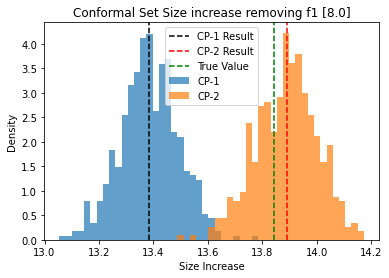

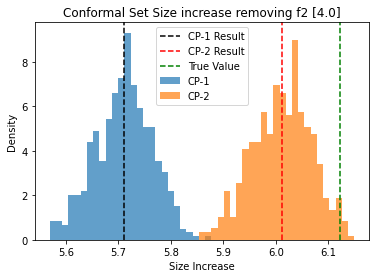

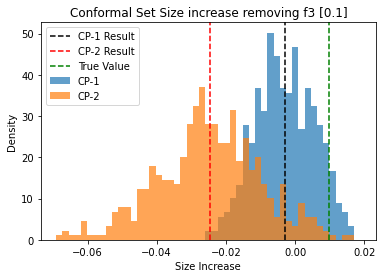

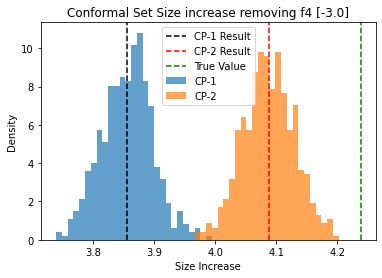

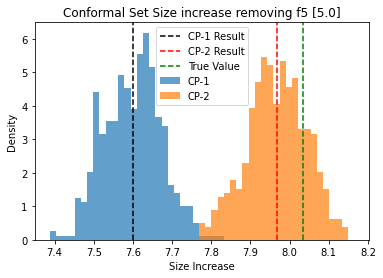

In [90]:
for i, variable in enumerate(lineardatacorr.calib_data_X.columns):

    data_1 = np.array(boot_size_1[variable]) - np.array(boot_size)
    data_2 = np.array(boot_size_2[variable]) - np.array(boot_size)

    # fixed bin size
    bins = np.arange(min(min(data_1), min(data_2)), max(max(data_1), max(data_2)), (max(max(data_1), 
                     max(data_2))-min(min(data_1), min(data_2)))/50) # fixed bin size
    # bins = 50

    # plt.xlim([min(0, min(data))-5, max(data)+5])

    plt.hist(data_1, bins=bins, alpha=0.7, density=True, label='CP-1')
    plt.hist(data_2, bins=bins, alpha=0.7, density=True, label='CP-2')
    plt.axvline(x=np.mean(data_1), color='black', linestyle='--', label='CP-1 Result')
    plt.axvline(x=np.mean(data_2), color='red', linestyle='--', label='CP-2 Result')
    plt.axvline(x=foldnorm.ppf(q = 0.95, c = 0, scale = np.sqrt((weights[i]**2)*std**2+std**2))*2-foldnorm.ppf(q = 0.95, c = 0, scale = std)*2, 
                color='green', linestyle='--', label='True Value')
    plt.title('Conformal Set Size increase removing ' + variable + ' [' + str(weights[i]) + ']')
    plt.xlabel('Size Increase')
    plt.ylabel('Density')
    plt.legend()
    plt.savefig('images/Linear_data/rf_5_feat_true_val_'+variable)
    plt.show()